# Create a Network from GeoDataFrame

<a href=https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.convert.graph_from_gdfs>`ox.graph_from_gdfs`</a> is a function in the OSMnx library that allows you to create a graph from two GeoDataFrames: one for nodes and one for edges. This function is useful when you have spatial data in the form of GeoDataFrames and want to convert it into a graph structure for analysis or visualization.
<br>

osmnx.convert.graph_from_gdfs(gdf_nodes, gdf_edges, *, graph_attrs=None)

To use this function, you need to match the nodes and edges in the GeoDataFrames with the graph structure. The nodes should be uniquely indexed by their IDs, and the edges should be uniquely multi-indexed by a combination of two nodes (u, v) and an optional key.
* gdf_nodes (GeoDataFrame) – GeoDataFrame of graph nodes uniquely indexed by osmid.
* gdf_edges (GeoDataFrame) – GeoDataFrame of graph edges uniquely multi-indexed by (u, v, key).

In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from tqdm import tqdm

In [2]:
nodes_viewt_seoul = gpd.read_file('./data/seoul_lev6_2023/seoul_node_lev6_2023.shp', encoding='cp949')
edges_viewt_seoul = gpd.read_file('./data/seoul_lev6_2023/seoul_link_lev6_2023.shp', encoding='cp949')
nodes_viewt_incheon = gpd.read_file('./data/incheon_lev6_2023/incheon_node_lev6_2023.shp', encoding='cp949')
edges_viewt_incheon = gpd.read_file('./data/incheon_lev6_2023/incheon_link_lev6_2023.shp', encoding = 'cp949')
nodes_viewt_gyeonggi = gpd.read_file('./data/gyeonggi_lev6_2023/gyeonggi_node_lev6_2023.shp', encoding='cp949')
edges_viewt_gyeonggi = gpd.read_file('./data/gyeonggi_lev6_2023/gyeonggi_link_lev6_2023.shp', encoding='cp949')

In [5]:
edges_viewt_seoul.head(3)
# print(edges_viewt_seoul.nunique())
#nodes_viewt_seoul.head(3)

,link_id,up_f_node,up_t_node,dw_f_node,dw_t_node,max_speed,road_name,road_no,road_rank,link_type,...,dw_v_link,rc_id,rc_name,rc_hist,rc_date,rc_length,old_link_i,source,remark,geometry
0,477601490.0,201446.0,201756.0,201756.0,201446.0,30.0,경인로47길,0,104.0,32768.0,...,4.776015e+10,None,None,None,NaN,NaN,0.0,0,None,"LINESTRING (944108.527 1944675.953, 944047.937..."
1,477603521.0,201784.0,218316.0,218316.0,201784.0,30.0,구일로10길,0,104.0,32768.0,...,4.776035e+10,None,None,None,NaN,NaN,0.0,0,None,"LINESTRING (944456.454 1944199.04, 944567.445 ..."
2,477603522.0,201452.0,201784.0,201784.0,201452.0,50.0,구일로,0,104.0,32768.0,...,4.776035e+10,None,None,None,NaN,NaN,0.0,0,None,"LINESTRING (944483.311 1944011.816, 944475.981..."


<Axes: >

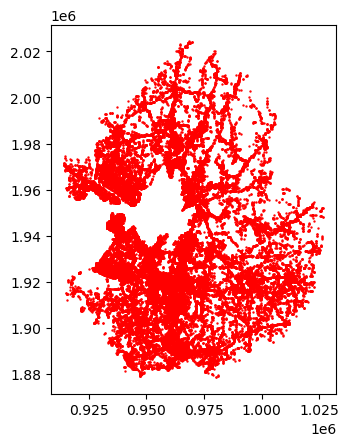

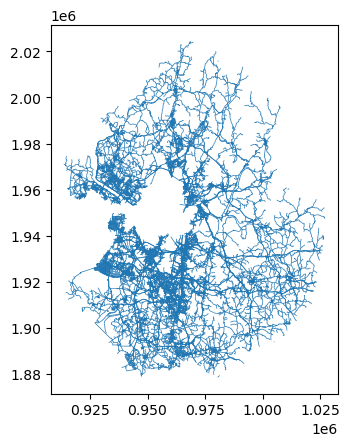

In [5]:
nodes_viewt_gyeonggi.plot(color = 'red', markersize = 0.5)
edges_viewt_gyeonggi.plot(linewidth = 0.5)

In [6]:
# merge the three regions into one GeoDataFrame
nodes = pd.concat([nodes_viewt_seoul, nodes_viewt_incheon, nodes_viewt_gyeonggi], ignore_index = True)
edges = pd.concat([edges_viewt_seoul, edges_viewt_incheon, edges_viewt_gyeonggi], ignore_index = True)
# edges
# nodes

In [7]:
emd_gdf = gpd.read_file('./data/emd_5179.geojson')
emd_gdf['ADM_CD'] = emd_gdf['ADM_CD'].astype(str)
emd_gdf = emd_gdf.loc[emd_gdf['ADM_CD'].str.startswith('11240')]
emd_gdf = emd_gdf.dissolve(by = 'BASE_DATE')
emd_gdf

,geometry,ADM_NM,ADM_CD
BASE_DATE,,,
20230701,"POLYGON ((965333.001 1943389.232, 965332.628 1...",장지동,11240810


In [8]:
# Select only the nodes and edges that intersect with the EMD geometry
# This is for a demonstration purpose
# nodes_viewt_seoul = nodes_viewt_seoul.loc[nodes_viewt_seoul['geometry'].intersects(emd_gdf['geometry'].values[0])]
# edges_viewt_seoul = edges_viewt_seoul.loc[edges_viewt_seoul['geometry'].intersects(emd_gdf['geometry'].values[0])]

## 2. Match the nodes with the graph structure

In [9]:
nodes.head(3)
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 150972 entries, 0 to 150971
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   node_id     150972 non-null  float64 
 1   node_type   150972 non-null  object  
 2   node_name   22474 non-null   object  
 3   num_link    150972 non-null  float64 
 4   turn_info   4924 non-null    object  
 5   x           150972 non-null  object  
 6   y           150972 non-null  object  
 7   sido_id     150972 non-null  float64 
 8   sigungu_id  150972 non-null  float64 
 9   emd_id      150972 non-null  float64 
 10  m_date      150972 non-null  float64 
 11  rc_id       1885 non-null    object  
 12  rc_hist     20175 non-null   object  
 13  old_node_i  7003 non-null    float64 
 14  remark      1061 non-null    object  
 15  tra_light   150972 non-null  object  
 16  geometry    150972 non-null  geometry
dtypes: float64(7), geometry(1), object(9)
memory usage: 19.6+ M

In [10]:
nodes_gdf = nodes.copy()

nodes_gdf['node_id'] = nodes_gdf['node_id'].astype(int)
nodes_gdf['node_id'] = nodes_gdf['node_id'].astype(str)

nodes_gdf['node_type'] = nodes_gdf['node_type'].astype(int) # Remove decimal point
nodes_gdf['node_type'] = nodes_gdf['node_type'].astype(str) # Change to string

# Assign the coordinates as columns
nodes_gdf['y'] = nodes_gdf['geometry'].y
nodes_gdf['x'] = nodes_gdf['geometry'].x

nodes_gdf = nodes_gdf[['node_id', 'node_type', 'geometry', 'x', 'y']] # Remove unnecessary columns

# Match Scheme with OSMnx
nodes_gdf = nodes_gdf.set_index('node_id')

nodes_gdf.head(3)

,node_type,geometry,x,y
node_id,,,,
201345,101,POINT (940053.394 1943848.591),940053.394447,1.943849e+06
201391,101,POINT (943106.602 1943217.947),943106.602350,1.943218e+06
201392,101,POINT (943109.786 1943171.169),943109.786484,1.943171e+06


## 3. Match the edges with the graph structure

In [11]:
# original data
edges.head(3)
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 192427 entries, 0 to 192426
Data columns (total 37 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   link_id     192427 non-null  float64 
 1   up_f_node   192427 non-null  float64 
 2   up_t_node   192427 non-null  float64 
 3   dw_f_node   192427 non-null  float64 
 4   dw_t_node   192427 non-null  float64 
 5   max_speed   192427 non-null  float64 
 6   road_name   154952 non-null  object  
 7   road_no     192030 non-null  object  
 8   road_rank   192427 non-null  float64 
 9   link_type   192427 non-null  float64 
 10  pavement    191637 non-null  float64 
 11  road_type   192427 non-null  float64 
 12  facil_name  7459 non-null    object  
 13  tg_name     348 non-null     object  
 14  up_lanes    192427 non-null  float64 
 15  dw_lanes    192427 non-null  float64 
 16  lanes       192427 non-null  float64 
 17  oneway      192427 non-null  float64 
 18  length      1924

In [12]:
edges.columns

Index(['link_id', 'up_f_node', 'up_t_node', 'dw_f_node', 'dw_t_node',
       'max_speed', 'road_name', 'road_no', 'road_rank', 'link_type',
       'pavement', 'road_type', 'facil_name', 'tg_name', 'up_lanes',
       'dw_lanes', 'lanes', 'oneway', 'length', 'level', 'up_its_id',
       'dw_its_id', 'sido_id', 'sigungu_id', 'emd_id', 'm_date', 'up_v_link',
       'dw_v_link', 'rc_id', 'rc_name', 'rc_hist', 'rc_date', 'rc_length',
       'old_link_i', 'source', 'remark', 'geometry'],
      dtype='object')

In [13]:
# To become a MultiDiGraph, the edges should be duplicated for two-way roads
# and the geometry should be reversed for the reverse direction
# If the road is one-way, the geometry should be kept as is

edges_gdf = gpd.GeoDataFrame()

for idx, row in tqdm(edges.iterrows(), total=edges.shape[0]):
    if row['oneway'] == 0: # If the road is two-way, duplicate the row with reversed geometry
        # Create a new row with non-reversed geometry
        edges_gdf = pd.concat([gpd.GeoDataFrame({'link_id': row['up_v_link'], 
                                            'f_node': row['up_f_node'], 
                                            't_node': row['up_t_node'], 
                                            'max_speed': row['max_speed'],
                                            'road_name': row['road_name'],
                                            'road_rank': row['road_rank'],
                                            'link_type': row['link_type'],
                                            'geometry': row['geometry']
                                            }, index=[0]), edges_gdf])
        
        # Add the reverse direction
        edges_gdf = pd.concat([gpd.GeoDataFrame({'link_id': row['dw_v_link'], 
                                            'f_node': row['dw_f_node'], 
                                            't_node': row['dw_t_node'], 
                                            'max_speed': row['max_speed'],
                                            'road_name': row['road_name'],
                                            'road_rank': row['road_rank'],
                                            'link_type': row['link_type'],
                                            'geometry': row['geometry'].reverse()
                                            }, index=[0]), edges_gdf])
    else:
        # If the road is one-way, keep the row as is
        edges_gdf = pd.concat([gpd.GeoDataFrame({'link_id': row['up_v_link'], 
                                            'f_node': row['up_f_node'], 
                                            't_node': row['up_t_node'], 
                                            'max_speed': row['max_speed'],
                                            'road_name': row['road_name'],
                                            'road_rank': row['road_rank'],
                                            'link_type': row['link_type'],
                                            'geometry': row['geometry']
                                            }, index=[0]), edges_gdf])

# Reset the index
edges_gdf = edges_gdf.reset_index(drop=True)

# Assign the same CRS 
edges_gdf = edges_gdf.set_crs(edges.crs) 
edges_gdf

100%|██████████| 192427/192427 [31:12<00:00, 102.78it/s]


,link_id,f_node,t_node,max_speed,road_name,road_rank,link_type,geometry
0,2.023003e+11,20230843.0,20230847.0,30.0,수도권제2순환고속도로,101.0,16.0,"LINESTRING (981777.443 1969712.307, 981777.687..."
1,2.023003e+11,20230799.0,20231827.0,40.0,수도권제2순환고속도로,108.0,8.0,"LINESTRING (970063.471 1978931.902, 970066.301..."
2,2.023003e+11,20231827.0,20230799.0,40.0,수도권제2순환고속도로,108.0,8.0,"LINESTRING (969891.619 1978809.013, 969892.099..."
3,2.023003e+11,20231825.0,20230854.0,30.0,수도권제2순환고속도로,101.0,16.0,"LINESTRING (981716.431 1970372.465, 981717.471..."
4,2.023003e+11,20230854.0,20231825.0,30.0,수도권제2순환고속도로,101.0,16.0,"LINESTRING (981708.598 1970204.837, 981699.233..."
...,...,...,...,...,...,...,...,...
333640,4.776035e+10,201452.0,201784.0,50.0,구일로,104.0,32768.0,"LINESTRING (944483.311 1944011.816, 944475.981..."
333641,4.776035e+10,218316.0,201784.0,30.0,구일로10길,104.0,32768.0,"LINESTRING (944630.07 1944206.083, 944567.445 ..."
333642,4.776035e+10,201784.0,218316.0,30.0,구일로10길,104.0,32768.0,"LINESTRING (944456.454 1944199.04, 944567.445 ..."
333643,4.776015e+10,201756.0,201446.0,30.0,경인로47길,104.0,32768.0,"LINESTRING (944047.937 1944732.673, 944108.527..."


In [14]:
edges_gdf['length'] = edges_gdf.apply(lambda x: x['geometry'].length, axis=1) # Calculate length in meters

# Change the data type of columns
edges_gdf['link_id'] = edges_gdf['link_id'].astype(int) # Remove decimal point
edges_gdf['link_id'] = edges_gdf['link_id'].astype(str) # Change to string

edges_gdf['f_node'] = edges_gdf['f_node'].astype(int) # Remove decimal point
edges_gdf['f_node'] = edges_gdf['f_node'].astype(str) # Change to string

edges_gdf['t_node'] = edges_gdf['t_node'].astype(int) # Remove decimal point
edges_gdf['t_node'] = edges_gdf['t_node'].astype(str) # Change to string

edges_gdf['road_rank'] = edges_gdf['road_rank'].astype(int) # Remove decimal point
edges_gdf['road_rank'] = edges_gdf['road_rank'].astype(str) # Change to string

edges_gdf['link_type'] = edges_gdf['link_type'].astype(int) # Remove decimal point
edges_gdf['link_type'] = edges_gdf['link_type'].astype(str) # Change to string

edges_gdf['max_speed'] = edges_gdf['max_speed'].astype(int) # Remove decimal point

edges_gdf.head(3)

,link_id,f_node,t_node,max_speed,road_name,road_rank,link_type,geometry,length
0,202300272101,20230843,20230847,30,수도권제2순환고속도로,101,16,"LINESTRING (981777.443 1969712.307, 981777.687...",342.622314
1,202300272002,20230799,20231827,40,수도권제2순환고속도로,108,8,"LINESTRING (970063.471 1978931.902, 970066.301...",424.275181
2,202300272001,20231827,20230799,40,수도권제2순환고속도로,108,8,"LINESTRING (969891.619 1978809.013, 969892.099...",424.275181


## 4. Assign information(travel speed and travel time) to the edges

In [ ]:
# Load speed data, also from ViewT
speed_seoul = pd.read_csv('./data/PercentileSpeed_202309_seoul.csv')
speed_gyeonggi = pd.read_csv('./data/PercentileSpeed_202309_Gyeonggi.csv')
speed_incheon = pd.read_csv('./data/PercentileSpeed_202309_incheon.csv')

print(speed_gyeonggi.index.nunique(), speed_seoul.index.nunique(), speed_incheon.index.nunique())
speed_df = pd.concat([speed_seoul, speed_gyeonggi, speed_incheon])
speed_df = speed_df.loc[speed_df['주요시간대'] == 8].reset_index(drop=True)
speed_df


24039 4291 1462


,﻿level6 LINK ID,연월,평일 / 주말,주요시간대,도로등급,시도명,시군구명,읍면동명,15% 주행속도 (km/h),25% 주행속도 (km/h),30% 주행속도 (km/h),50% 주행속도 (km/h),75% 주행속도 (km/h),85% 주행속도 (km/h),평균속도 (km/h),속도 표준편차 (km/h),최대속도 (km/h)
711,47771326001,202309,평일,8,고속도로,서울특별시,강서구,방화3동,84,89,91,96,103,107,96.52,12.59,149
712,47771347001,202309,평일,8,고속도로,서울특별시,강서구,방화3동,86,90,91,97,106,111,97.96,12.81,158
713,47771447401,202309,평일,8,고속도로,서울특별시,강서구,방화2동,85,89,91,96,103,107,96.05,10.62,146
714,47771448501,202309,평일,8,고속도로,서울특별시,강서구,방화2동,91,95,96,102,111,116,103.14,12.79,160
715,47771849901,202309,평일,8,고속도로,서울특별시,강서구,방화2동,85,89,90,97,105,108,96.91,12.32,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,47655091401,202309,평일,8,도시고속도로,인천광역시,남동구,논현고잔동,70,74,76,82,90,94,81.96,11.91,126
483,47655103401,202309,평일,8,도시고속도로,인천광역시,남동구,논현고잔동,51,58,60,66,73,77,64.19,14.49,109
484,47655103601,202309,평일,8,도시고속도로,인천광역시,남동구,논현고잔동,55,61,63,69,77,81,67.91,13.73,135
485,47655103801,202309,평일,8,도시고속도로,인천광역시,남동구,논현고잔동,55,63,65,73,82,87,71.05,17.10,124


In [16]:
# Select only the necessary columns
speed_df = speed_df[['﻿level6 LINK ID',  '30% 주행속도 (km/h)']]
speed_df = speed_df.rename(columns={'﻿level6 LINK ID': 'link_id', '30% 주행속도 (km/h)': 'speed'})
                                    # '평균속도 (km/h)': 'avg_speed'})
speed_df['link_id'] = speed_df['link_id'].astype(str)
speed_df

,link_id,speed
0,47771326001,91
1,47771347001,92
2,47771447401,91
3,47771448501,97
4,47771849901,92
...,...,...
1457,47655091401,73
1458,47655103401,57
1459,47655103601,54
1460,47655103801,50


In [17]:
# Merge the spped data with the edges data
edges_gdf = edges_gdf.merge(speed_df, on='link_id', how='left')
edges_gdf

,link_id,f_node,t_node,max_speed,road_name,road_rank,link_type,geometry,length,speed
0,202300272101,20230843,20230847,30,수도권제2순환고속도로,101,16,"LINESTRING (981777.443 1969712.307, 981777.687...",342.622314,NaN
1,202300272002,20230799,20231827,40,수도권제2순환고속도로,108,8,"LINESTRING (970063.471 1978931.902, 970066.301...",424.275181,NaN
2,202300272001,20231827,20230799,40,수도권제2순환고속도로,108,8,"LINESTRING (969891.619 1978809.013, 969892.099...",424.275181,NaN
3,202300271902,20231825,20230854,30,수도권제2순환고속도로,101,16,"LINESTRING (981716.431 1970372.465, 981717.471...",185.876610,11.0
4,202300271902,20231825,20230854,30,수도권제2순환고속도로,101,16,"LINESTRING (981716.431 1970372.465, 981717.471...",185.876610,10.0
...,...,...,...,...,...,...,...,...,...,...
358422,47760352201,201452,201784,50,구일로,104,32768,"LINESTRING (944483.311 1944011.816, 944475.981...",189.140811,NaN
358423,47760352102,218316,201784,30,구일로10길,104,32768,"LINESTRING (944630.07 1944206.083, 944567.445 ...",173.776734,NaN
358424,47760352101,201784,218316,30,구일로10길,104,32768,"LINESTRING (944456.454 1944199.04, 944567.445 ...",173.776734,NaN
358425,47760149002,201756,201446,30,경인로47길,104,32768,"LINESTRING (944047.937 1944732.673, 944108.527...",82.995861,NaN


In [18]:
# Find the cells with missing speed data
edges_gdf.loc[(edges_gdf['speed'].isna()) | (edges_gdf['speed'] == 0)]  # speed 값이 없거나 0인 행 찾기

,link_id,f_node,t_node,max_speed,road_name,road_rank,link_type,geometry,length,speed
0,202300272101,20230843,20230847,30,수도권제2순환고속도로,101,16,"LINESTRING (981777.443 1969712.307, 981777.687...",342.622314,NaN
1,202300272002,20230799,20231827,40,수도권제2순환고속도로,108,8,"LINESTRING (970063.471 1978931.902, 970066.301...",424.275181,NaN
2,202300272001,20231827,20230799,40,수도권제2순환고속도로,108,8,"LINESTRING (969891.619 1978809.013, 969892.099...",424.275181,NaN
7,202300271801,20230829,20231826,50,수도권제2순환고속도로,108,8,"LINESTRING (984900.092 1965809.577, 984894.039...",158.839887,NaN
8,202300271701,20230801,20231824,50,수도권제2순환고속도로,108,8,"LINESTRING (976712.875 1974657.234, 976656.169...",263.365084,NaN
...,...,...,...,...,...,...,...,...,...,...
358422,47760352201,201452,201784,50,구일로,104,32768,"LINESTRING (944483.311 1944011.816, 944475.981...",189.140811,NaN
358423,47760352102,218316,201784,30,구일로10길,104,32768,"LINESTRING (944630.07 1944206.083, 944567.445 ...",173.776734,NaN
358424,47760352101,201784,218316,30,구일로10길,104,32768,"LINESTRING (944456.454 1944199.04, 944567.445 ...",173.776734,NaN
358425,47760149002,201756,201446,30,경인로47길,104,32768,"LINESTRING (944047.937 1944732.673, 944108.527...",82.995861,NaN


In [19]:
# Fill the missing speed data based on the road rank
for idx, row in edges_gdf.loc[(edges_gdf['speed'].isna()) | (edges_gdf['speed'] == 0)].iterrows():

    if row['road_rank'] == '101': # 고속도로
        edges_gdf.at[idx, 'speed'] = 100
    elif row['road_rank'] == '102': # 도시고속도로
        edges_gdf.at[idx, 'speed'] = 80
    # 일반국도, 특별/광역시도, 국가지원지방도, 일반지방도, 시군도
    elif row['road_rank'] in ['103', '104', '105', '106', '107']: 
        edges_gdf.at[idx, 'speed'] = 50
    elif row['road_rank'] == '108': # 고속도로 연결램프
        edges_gdf.at[idx, 'speed'] = 40
    else:
        raise ValueError('Unexpected Road Rank')            

In [20]:
edges_gdf.loc[edges_gdf['speed'].isna()]

,link_id,f_node,t_node,max_speed,road_name,road_rank,link_type,geometry,length,speed


In [21]:
# Match Scheme with OSMnx
edges_gdf = edges_gdf.rename(columns={'f_node': 'u', 't_node': 'v'}) #  , 'link_id': 'osmid'})
edges_gdf['key'] = 0
edges_gdf = edges_gdf.set_index(['u', 'v', 'key'])
edges_gdf.head(3)

,,,link_id,max_speed,road_name,road_rank,link_type,geometry,length,speed
u,v,key,,,,,,,,
20230843,20230847,0,202300272101,30,수도권제2순환고속도로,101,16,"LINESTRING (981777.443 1969712.307, 981777.687...",342.622314,100.0
20230799,20231827,0,202300272002,40,수도권제2순환고속도로,108,8,"LINESTRING (970063.471 1978931.902, 970066.301...",424.275181,40.0
20231827,20230799,0,202300272001,40,수도권제2순환고속도로,108,8,"LINESTRING (969891.619 1978809.013, 969892.099...",424.275181,40.0


In [22]:
edges_gdf.index.get_level_values('u').isin(nodes_gdf.index)

array([ True,  True,  True, ...,  True,  True,  True], shape=(358427,))

In [23]:
# Remove edges that are not connected to the nodes
edges_gdf = edges_gdf.loc[(edges_gdf.index.get_level_values('u').isin(nodes_gdf.index)) & 
                          (edges_gdf.index.get_level_values('v').isin(nodes_gdf.index))
                         ]
edges_gdf

link_id  max_speed    road_name road_rank  \
u        v        key                                                   
20230843 20230847 0    202300272101         30  수도권제2순환고속도로       101   
20230799 20231827 0    202300272002         40  수도권제2순환고속도로       108   
20231827 20230799 0    202300272001         40  수도권제2순환고속도로       108   
20231825 20230854 0    202300271902         30  수도권제2순환고속도로       101   
                  0    202300271902         30  수도권제2순환고속도로       101   
...                             ...        ...          ...       ...   
201452   201784   0     47760352201         50          구일로       104   
218316   201784   0     47760352102         30       구일로10길       104   
201784   218316   0     47760352101         30       구일로10길       104   
201756   201446   0     47760149002         30       경인로47길       104   
201446   201756   0     47760149001         30       경인로47길       104   

                      link_type  \
u        v        key             
20230843 20230847 0          16   
20230799 20231827 0           8   
20231827 20230799 0           8   
20231825 20230854 0          16   
                  0          16   
...                         ...   
201452   201784   0       32768   
218316   201784   0       32768   
201784   218316   0       32768   
201756   201446   0       32768   
201446   201756   0       32768   

                                                                geometry  \
u        v        key                                                      
20230843 20230847 0    LINESTRING (981777.443 1969712.307, 981777.687...   
20230799 20231827 0    LINESTRING (970063.471 1978931.902, 970066.301...   
20231827 20230799 0    LINESTRING (969891.619 1978809.013, 969892.099...   
20231825 20230854 0    LINESTRING (981716.431 1970372.465, 981717.471...   
                  0    LINESTRING (981716.431 1970372.465, 981717.471...   
...                                                                  ...   
201452   201784   0    LINESTRING (944483.311 1944011.816, 944475.981...   
218316   201784   0    LINESTRING (944630.07 1944206.083, 944567.445 ...   
201784   218316   0    LINESTRING (944456.454 1944199.04, 944567.445 ...   
201756   201446   0    LINESTRING (944047.937 1944732.673, 944108.527...   
201446   201756   0    LINESTRING (944108.527 1944675.953, 944047.937...   

                           length  speed  
u        v        key                     
20230843 20230847 0    342.622314  100.0  
20230799 20231827 0    424.275181   40.0  
20231827 20230799 0    424.275181   40.0  
20231825 20230854 0    185.876610   11.0  
                  0    185.876610   10.0  
...                           ...    ...  
201452   201784   0    189.140811   50.0  
218316   201784   0    173.776734   50.0  
201784   218316   0    173.776734   50.0  
201756   201446   0     82.995861   50.0  
201446   201756   0     82.995861   50.0  

[358300 rows x 8 columns]

In [24]:
# Double check if there are any edges with speed 0
edges_gdf.loc[edges_gdf['speed'] == 0]

,,,link_id,max_speed,road_name,road_rank,link_type,geometry,length,speed
u,v,key,,,,,,,,


In [25]:
# Calculate the travel time for each edge
# travel_time = length / speed
# Convert speed from km/h to m/s
edges_gdf['travel_time'] = edges_gdf.apply(lambda x: x['length'] / (x['speed'] * 1000 / 3600), axis=1)
edges_gdf

link_id  max_speed    road_name road_rank  \
u        v        key                                                   
20230843 20230847 0    202300272101         30  수도권제2순환고속도로       101   
20230799 20231827 0    202300272002         40  수도권제2순환고속도로       108   
20231827 20230799 0    202300272001         40  수도권제2순환고속도로       108   
20231825 20230854 0    202300271902         30  수도권제2순환고속도로       101   
                  0    202300271902         30  수도권제2순환고속도로       101   
...                             ...        ...          ...       ...   
201452   201784   0     47760352201         50          구일로       104   
218316   201784   0     47760352102         30       구일로10길       104   
201784   218316   0     47760352101         30       구일로10길       104   
201756   201446   0     47760149002         30       경인로47길       104   
201446   201756   0     47760149001         30       경인로47길       104   

                      link_type  \
u        v        key             
20230843 20230847 0          16   
20230799 20231827 0           8   
20231827 20230799 0           8   
20231825 20230854 0          16   
                  0          16   
...                         ...   
201452   201784   0       32768   
218316   201784   0       32768   
201784   218316   0       32768   
201756   201446   0       32768   
201446   201756   0       32768   

                                                                geometry  \
u        v        key                                                      
20230843 20230847 0    LINESTRING (981777.443 1969712.307, 981777.687...   
20230799 20231827 0    LINESTRING (970063.471 1978931.902, 970066.301...   
20231827 20230799 0    LINESTRING (969891.619 1978809.013, 969892.099...   
20231825 20230854 0    LINESTRING (981716.431 1970372.465, 981717.471...   
                  0    LINESTRING (981716.431 1970372.465, 981717.471...   
...                                                                  ...   
201452   201784   0    LINESTRING (944483.311 1944011.816, 944475.981...   
218316   201784   0    LINESTRING (944630.07 1944206.083, 944567.445 ...   
201784   218316   0    LINESTRING (944456.454 1944199.04, 944567.445 ...   
201756   201446   0    LINESTRING (944047.937 1944732.673, 944108.527...   
201446   201756   0    LINESTRING (944108.527 1944675.953, 944047.937...   

                           length  speed  travel_time  
u        v        key                                  
20230843 20230847 0    342.622314  100.0    12.334403  
20230799 20231827 0    424.275181   40.0    38.184766  
20231827 20230799 0    424.275181   40.0    38.184766  
20231825 20230854 0    185.876610   11.0    60.832345  
                  0    185.876610   10.0    66.915579  
...                           ...    ...          ...  
201452   201784   0    189.140811   50.0    13.618138  
218316   201784   0    173.776734   50.0    12.511925  
201784   218316   0    173.776734   50.0    12.511925  
201756   201446   0     82.995861   50.0     5.975702  
201446   201756   0     82.995861   50.0     5.975702  

[358300 rows x 9 columns]

<Axes: >

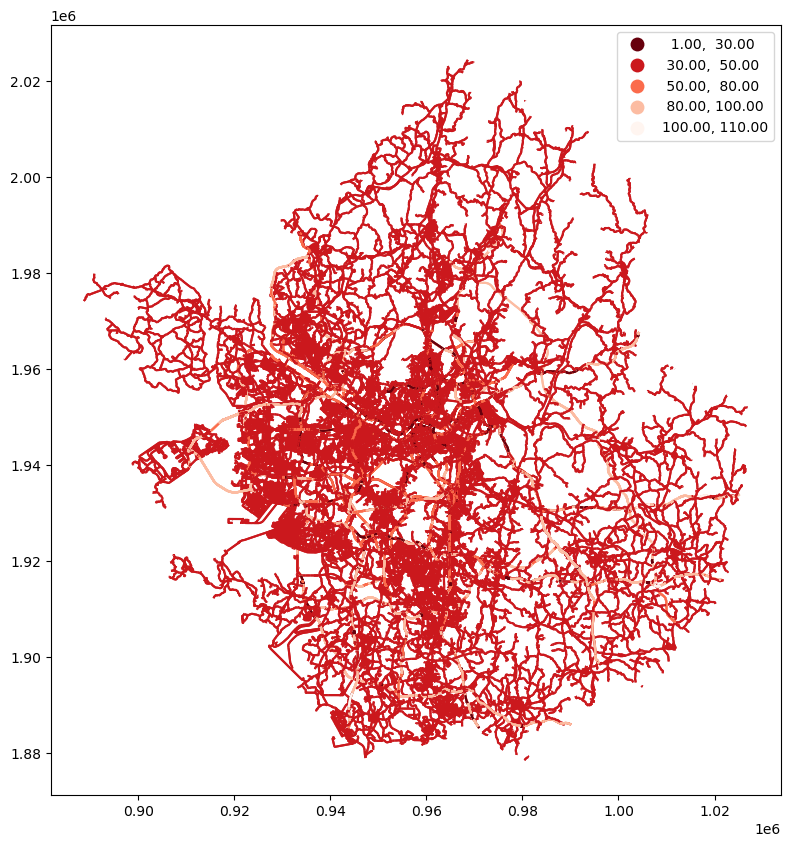

In [26]:
edges_gdf.plot(column='speed', cmap='Reds_r', 
               legend=True, 
               scheme='UserDefined',
                classification_kwds={'bins': [30, 50, 80, 100]},
                figsize=(10, 10))

## 5. Convert the GeoDataFrames to a graph

In [27]:
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)
ox.plot_graph(G, figsize = (10,10))

ValueError: `gdf_nodes` and `gdf_edges` must each be uniquely indexed.

## 6. Check the graph (i.e., remove disconnected nodes)

We can remove disconnected nodes from the graph using nx.strongly_connected_components() function. This function returns a list of strongly connected components in the graph, which can identify a subgraph that is unreachable from other nodes/vertices of a graph or subgraph. 

In [ ]:
list(nx.strongly_connected_components(G))

In [ ]:
abc = [c for c in sorted(nx.strongly_connected_components(G), key=len, reverse = True)]
abc

In [ ]:
nodes_gdf.loc[nodes_gdf.index.isin(abc[4])].explore()

In [ ]:
# With max function, we can find the largest connected component
largest_section = max(nx.strongly_connected_components(G), key=len)
largest_section

In [ ]:
# G.subgraph will clip the graph with the nodes provided
# This will create a new graph with only the nodes in the largest section
G = G.subgraph(largest_section)
ox.plot_graph(G)

In [ ]:
# You can save the graph to a file
# ox.save_graphml(G, './data/road_network_seoul.graphml')